In [1]:
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [2]:
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.data import DataStore
from gammapy.datasets import Datasets, FluxPointsDataset
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, PointSpatialModel, PowerLawSpectralModel
from gammapy.irf import EDispKernel, PSFMap
from gammapy.datasets import Datasets, MapDataset
from regions import CircleSkyRegion, RectangleSkyRegion
from hawc_dataset import HAWCMapDataset
from gammapy.estimators import (
    FluxPoints,
    FluxPointsEstimator,
)
sys.path.append('/d22/hin/vikasj78/J1809-193_Analysis/hess-j1813/scripts')
from vikas_utils import get_excluded_regions

#### Model Definition

In [3]:
spatial_model = PointSpatialModel(
    lon_0="83.63 deg",
    lat_0="22.01 deg",
    frame="icrs"
)

spectral_model = LogParabolaSpectralModel(
        amplitude="2.6e-13 TeV-1 cm-2 s-1",
        alpha=2.65,
        beta=0.1,
        reference="7 TeV"
)

spectral_model.amplitude.error = "0.07e-13 TeV-1 cm-2 s-1"
spectral_model.beta.error = 0.015
spectral_model.alpha.error = 0.019

model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model, name='crab model')

#### Get the HAWC dataset

In [57]:
dataset_hawc = HAWCMapDataset.read("gp-hawc-maps/hawc-dataset.fits.gz", name="hawc")
dataset_hawc.models.append(model)
dataset_hawc.background_model.norm.frozen = True
# TODO: is the lowest nhit bin really excluded in the reference analysis?
dataset_hawc.mask_safe.data[0, :] = False
print(dataset_hawc.mask_safe.data.shape)

(9, 3833)


In [5]:
crab_model = dataset_hawc.models['crab model']
crab_spec = crab_model.spectral_model
print(crab_spec)

LogParabolaSpectralModel

   name     value        unit      min max frozen   error  
--------- --------- -------------- --- --- ------ ---------
amplitude 2.600e-13 cm-2 s-1 TeV-1 nan nan  False 7.000e-15
reference 7.000e+00            TeV nan nan   True 0.000e+00
    alpha 2.650e+00                nan nan  False 1.900e-02
     beta 1.000e-01                nan nan  False 1.500e-02


#### Now let's get the hess dataset

In [6]:
def save(fig, filename, left=0.15, bottom=0.15, top=0.95, right=0.95):
    savedir = '{}'.format(plotDir)
    fig.subplots_adjust(left=left, bottom=bottom, top=top, right=right)
    for form in ['png', 'pdf']:
        fig.savefig('{}/crab_joint_hess_hawc_{}.{}'.format(plotDir, filename, form))

In [7]:
dataset_hess = MapDataset.read('/lfs/l2/hawc/users/vikasj78/gammapyData/crab/dataset-bgfit-stacked.fits.gz',name='hess')

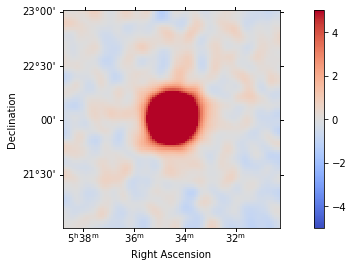

In [8]:
w_gauss = 0.05 * u.deg
# Residual excess map after the fit (clipped at +- 2 counts)
dataset_hess.plot_residuals(method='diff', smooth_radius=w_gauss)
fig = plt.gcf()
ax = fig.axes[0]

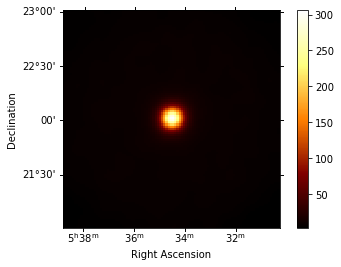

In [9]:
# Counts map
fig = dataset_hess.counts.sum_over_axes().smooth(w_gauss).plot(add_cbar=True)[0]

In [10]:
dataset_hess.models.append(crab_model)

In [11]:
datasets = Datasets([dataset_hess, dataset_hawc])

In [13]:
path = Path("crab-3datasets")
path.mkdir(exist_ok=True)
datasets.write(path=path, prefix="crab_hess_nHithawc_data_hess", overwrite=True)

In [14]:
%%time
fit_joint = Fit(datasets)
results_joint = fit_joint.run()
print(results_joint)
print(results_joint.parameters.to_table())

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed. Estimated distance to minimum too large.
	nfev       : 263
	total stat : -67189487.24

   name     value        unit         min        max    frozen   error  
--------- --------- -------------- ---------- --------- ------ ---------
     norm 1.000e+00                 0.000e+00       nan  False 3.635e-03
     tilt 0.000e+00                       nan       nan   True 0.000e+00
reference 1.000e+00            TeV        nan       nan   True 0.000e+00
amplitude 2.081e-13 cm-2 s-1 TeV-1        nan       nan  False 2.737e-15
reference 7.000e+00            TeV        nan       nan   True 0.000e+00
    alpha 2.750e+00                       nan       nan  False 1.284e-02
     beta 2.726e-02                       nan       nan  False 5.977e-03
    lon_0 8.363e+01            deg        nan       nan  False 3.161e-04
    lat_0 2.202e+01            deg -9.000e+01 9.000e+01  False 2.831e-

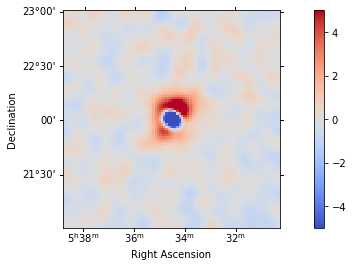

In [15]:
# Residual excess map after the fit (clipped at +- 2 counts)
dataset_hess.plot_residuals(method='diff', smooth_radius=w_gauss)
fig = plt.gcf()
ax = fig.axes[0]

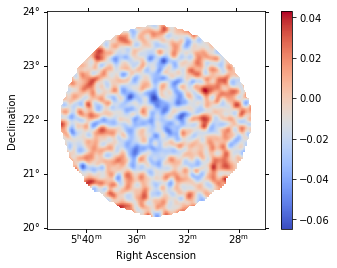

In [16]:
#residual hawc
npred = dataset_hawc.npred()
residuals = (dataset_hawc.counts - npred)/ np.sqrt(npred.data)
residuals.to_wcs().smooth("0.05 deg").plot_interactive(cmap="coolwarm", stretch="linear", add_cbar=True)

In [17]:
ref_model = LogParabolaSpectralModel(
    amplitude="2.54e-13 TeV-1 cm-2 s-1",
    alpha=2.646,
    beta=0.104,
    reference="7 TeV"
)
ref_model.amplitude.error = "0.07e-13 TeV-1 cm-2 s-1"
ref_model.beta.error = 0.015
ref_model.alpha.error = 0.019

In [32]:
#HESS flux points
ebins = np.logspace(-0.25, 2, 18)
eaxis = MapAxis.from_edges(ebins, unit='TeV', name='energy', interp='log')
flux_points_hess = FluxPointsEstimator(
    e_edges=eaxis.edges,  source="crab model").run([dataset_hess])
flux_points_hess.table["is_ul"] = flux_points_hess.table["ts"] < 4

RuntimeError: exception was raised in user function
User function arguments:
    par_000_norm = +1.000215


In [33]:
print(dataset_hess)

MapDataset
----------

  Name                            : hess 

  Total counts                    : 104363 
  Total predicted counts          : 103876.58
  Total background counts         : 79989.34

  Exposure min                    : 6.02e+09 m2 s
  Exposure max                    : 1.57e+11 m2 s

  Number of total bins            : 170000 
  Number of fit bins              : 170000 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 51982.49

  Number of models                : 2 
  Number of parameters            : 9
  Number of free parameters       : 6

  Component 0: BackgroundModel
  
    Name                      : hess-bkg
    Datasets names            : ['hess']
    Parameters:
      norm                    :   1.000              
      tilt         (frozen)   :   0.000              
      reference    (frozen)   :   1.000  TeV         
  
  Component 1: SkyModel
  
    Name                      : crab model
    Datasets names            : None
 

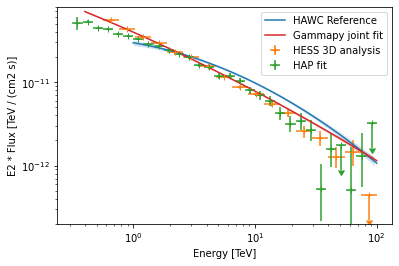

In [20]:
flux_points_tim = FluxPoints.read('crab_hess1_std_ImPACT_above20000_PL_fit.dat')
ax = ref_model.plot(energy_range=(1, 100) * u.TeV, energy_power=2, label="HAWC Reference")
ref_model.plot_error(energy_range=(1, 100) * u.TeV, energy_power=2, ax=ax, color=ax.lines[-1].get_color())
flux_points_hess.plot(ax=ax, energy_power=2, label="HESS 3D analysis")
flux_points_tim.plot(ax=ax, energy_power=2, label="HAP fit")
spectral_model.plot(ax=ax, energy_range=(0.4, 100) * u.TeV, energy_power=2, label="Gammapy joint fit")
spectral_model.plot_error(ax=ax, energy_range=(0.4, 100) * u.TeV, energy_power=2, color=ax.lines[-1].get_color())
ax.set_ylim(bottom=2.e-13, top=8.e-11)
plt.legend()
plt.savefig("plots/nHitHAWCHESS/energy-spectrum-joint-fit.png", dpi=300)

In [21]:
#HAWC excess residual after fitting
counts_hawc = dataset_hawc.counts.data.sum(axis=1)
npred_hawc = dataset_hawc.npred().data.sum(axis=1)
background_hawc = dataset_hawc.background_model.evaluate().get_spectrum().data.squeeze()
counts_residuals_hawc = (counts_hawc - npred_hawc) / np.sqrt(npred_hawc)

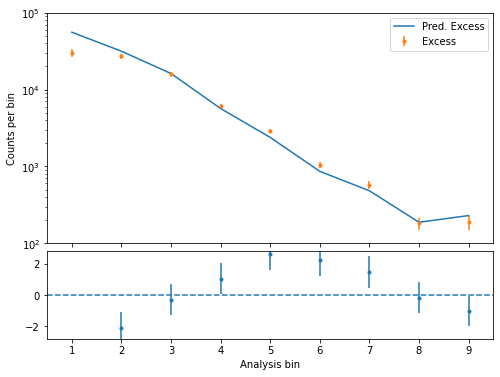

In [23]:
nhit_bins = np.arange(9) + 1
plt.figure(figsize=(8, 6))

gs = GridSpec(7, 1)

ax = plt.subplot(gs[:5, :])
ax.plot(nhit_bins, npred_hawc - background_hawc, label="Pred. Excess")

yerr = np.sqrt(counts_hawc)
ax.errorbar(nhit_bins, counts_hawc - background_hawc, yerr=yerr, marker='o', ms=3, label="Excess", ls="None")
ax.semilogy()
ax.set_ylim(1e2, 1e5)
ax.set_ylabel("Counts per bin")
plt.setp(ax.get_xticklabels(), visible=False)
plt.legend()

ax_residuals = plt.subplot(gs[5:, :], sharex=ax)
ax_residuals.hlines(0, 0.5, 9.5, ls="--", color="tab:blue")
ax_residuals.set_ylim(-2.8, 2.8)
ax_residuals.set_xlim(0.5, 9.5)
ax_residuals.set_yticks([-2, 0, 2])

yerr = yerr / np.sqrt(npred_hawc)
ax_residuals.errorbar(nhit_bins, counts_residuals_hawc, yerr=yerr, marker='o', ms=3, ls="None")

ax_residuals.set_xlabel("Analysis bin");
plt.savefig("plots/nHitHAWCHESS/residuals-spectrum.png", dpi=300)

In [24]:
#HESS excess residual after fitting
counts_hess = dataset_hess.to_image
#npred_hess = dataset_hess.npred().data.sum(axis=1)
#background_hess = dataset_hess.background_model.evaluate().get_spectrum().data.squeeze()
#counts_residuals_hess = (counts_hess - npred_hess) / np.sqrt(npred_hess)
print(counts_hess, type(counts_hess))
print(dataset_hess.data_shape)
dataset_hess

<bound method MapDataset.to_image of <gammapy.datasets.map.MapDataset object at 0x7f449d0e97b8>> <class 'method'>
(17, 100, 100)


In [25]:
datasets_stacked_per_thresh = {}
for i in range(5):
    datasets_stacked_per_thresh[i] = MapDataset.read('/lfs/l2/hawc/users/vikasj78/gammapyData/crab/dataset-bkg-fit-stacked-thresh-{:02d}.fits.gz'.format(i))

In [26]:
for ds in datasets_stacked_per_thresh.values():
    ds.models.append(model)

In [27]:
# Parameters before the fit
datasets_stacked_per_thresh[0].models.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
norm,1.000e+00,,0.000e+00,nan,False,0.000e+00
tilt,0.000e+00,,nan,nan,True,0.000e+00
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
amplitude,2.081e-13,cm-2 s-1 TeV-1,nan,nan,False,2.737e-15
reference,7.000e+00,TeV,nan,nan,True,0.000e+00
alpha,2.750e+00,,nan,nan,False,1.284e-02
beta,2.726e-02,,nan,nan,False,5.977e-03
lon_0,8.363e+01,deg,nan,nan,False,3.161e-04
lat_0,2.202e+01,deg,-9.000e+01,9.000e+01,False,2.831e-04


In [28]:
%%time
# Perform fit
datasets_semi_stacked_hess_and_hawc = {}
for i in range(6):
    if ( i < 5):
        datasets_semi_stacked_hess_and_hawc[i] = datasets_stacked_per_thresh[i]
    else:
        datasets_semi_stacked_hess_and_hawc[i] = dataset_hawc
fit_semi_stacked_joint = Fit(list(datasets_semi_stacked_hess_and_hawc.values()))
result_semi_stacked_joint = fit_semi_stacked_joint.run(optimize_opts=dict(print_level=1))

------------------------------------------------------------------
| FCN = -6.7E+07                |     Ncalls=322 (322 total)     |
| EDM = 0.0398 (Goal: 1E-05)    |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     False     |     True      |   True    |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
CPU times: user 1min 9s, sys: 10.9 s, total: 1min 20s
Wall time: 1min 20s


In [29]:
result_semi_stacked_joint.parameters.to_table()

name,value,unit,min,max,frozen,error
str9,float64,str14,float64,float64,bool,float64
norm,1.004e+00,,0.000e+00,nan,False,4.982e-03
tilt,0.000e+00,,nan,nan,True,0.000e+00
reference,1.000e+00,TeV,nan,nan,True,0.000e+00
amplitude,2.059e-13,cm-2 s-1 TeV-1,nan,nan,False,2.700e-15
reference,7.000e+00,TeV,nan,nan,True,0.000e+00
alpha,2.735e+00,,nan,nan,False,1.234e-02
beta,2.016e-02,,nan,nan,False,5.794e-03
lon_0,8.363e+01,deg,nan,nan,False,3.105e-04
lat_0,2.202e+01,deg,-9.000e+01,9.000e+01,False,2.782e-04


In [30]:
%%time
# Compute flux points for semi stacked(takes long)
fp_semi_stacked = FluxPointsEstimator(e_edges=eaxis.edges,reoptimize=True, source='crab model')
flux_points_semi_stacked = fp_semi_stacked.run(list(datasets_stacked_per_thresh.values()))
flux_points_semi_stacked.table["is_ul"] = flux_points_semi_stacked.table["ts"] < 4

Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed for parameter null value, returning NaN. Check input null value.
Fit failed f

CPU times: user 54min 44s, sys: 5.38 s, total: 54min 50s
Wall time: 55min


/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less
  result = getattr(super(), op)(other)


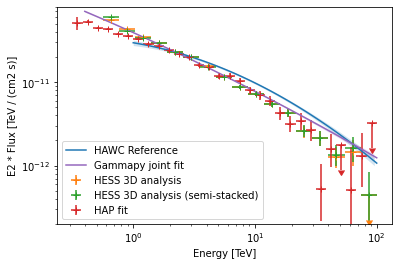

In [31]:
flux_points_tim = FluxPoints.read('crab_hess1_std_ImPACT_above20000_PL_fit.dat')
ax = ref_model.plot(energy_range=(1, 100) * u.TeV, energy_power=2, label="HAWC Reference")
ref_model.plot_error(energy_range=(1, 100) * u.TeV, energy_power=2, ax=ax, color=ax.lines[-1].get_color())
flux_points_hess.plot(ax=ax, energy_power=2, label="HESS 3D analysis")
flux_points_semi_stacked.plot(ax=ax, energy_power=2, label="HESS 3D analysis (semi-stacked)")
flux_points_tim.plot(ax=ax, energy_power=2, label="HAP fit")
spectral_model.plot(ax=ax, energy_range=(0.4, 100) * u.TeV, energy_power=2, label="Gammapy joint fit")
spectral_model.plot_error(ax=ax, energy_range=(0.4, 100) * u.TeV, energy_power=2, color=ax.lines[-1].get_color())
ax.set_ylim(bottom=2.e-13, top=8.e-11)
plt.legend()
plt.savefig("plots/nHitHAWCHESS/energy-spectrum-joint-fit-hess-semi-stacked.png", dpi=300)

In [50]:
print(type(datasets_stacked_per_thresh[0]))

<class 'gammapy.datasets.map.MapDataset'>


In [55]:
print(datasets_stacked_per_thresh[2].counts.data.shape)

(17, 100, 100)


In [56]:
print(datasets_stacked_per_thresh[2].background_model.evaluate().data.shape)

(17, 100, 100)
